# Imports

In [68]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import yfinance as yf
from arch import arch_model
from scipy import stats
import warnings 
warnings.filterwarnings('ignore')

# Data Analysis

In [69]:
ticker = "AAPL"
start_date = "2015-01-01"
end_date = "2024-12-31"


df = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

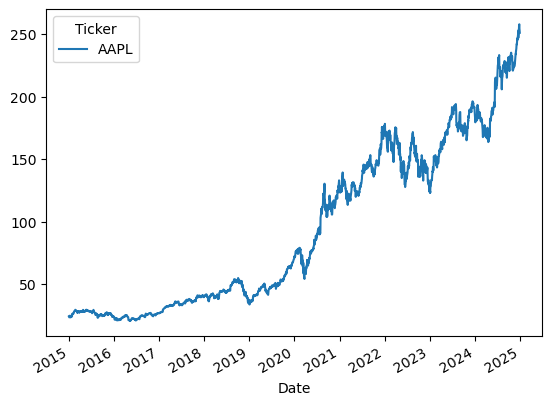

In [70]:
df.Close.plot()

In [71]:
returns = df.Close.pct_change().dropna()

array([[<Axes: title={'center': 'AAPL'}>]], dtype=object)

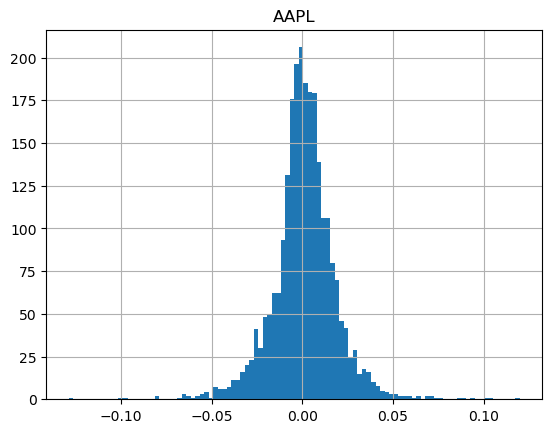

In [72]:
returns.hist(bins=100)

In [73]:
returns.describe()

Ticker,AAPL
count,2514.000000
mean,0.001091
std,0.017932
min,-0.128647
25%,-0.007328
50%,0.001001
75%,0.010143
max,0.119808


<Axes: xlabel='Date'>

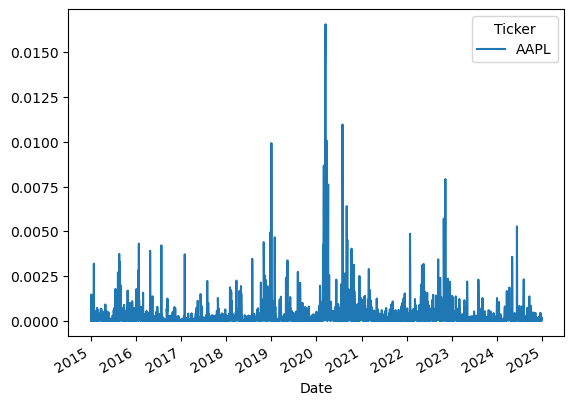

In [74]:
returns_sq = returns ** 2
returns_sq.plot()

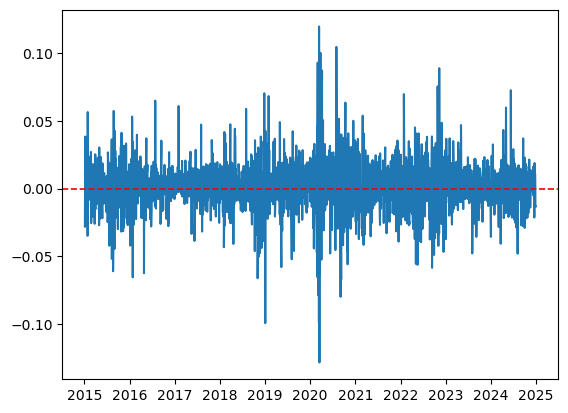

In [75]:
plt.plot(returns)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.2, label='y=0')
plt.show()

# GARCH(1,1) model

## Simple model

In [76]:
model = arch_model(returns, vol='Garch', p=1, q=1, dist='normal')

In [77]:
res = model.fit(update_freq=5, disp='off') 

In [78]:
print(res.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   AAPL   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                6773.73
Distribution:                  Normal   AIC:                          -13539.5
Method:            Maximum Likelihood   BIC:                          -13516.2
                                        No. Observations:                 2514
Date:                Thu, Oct 30 2025   Df Residuals:                     2513
Time:                        19:00:22   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.4864e-03  3.014e-04      4.932  8.127e-07 [8.

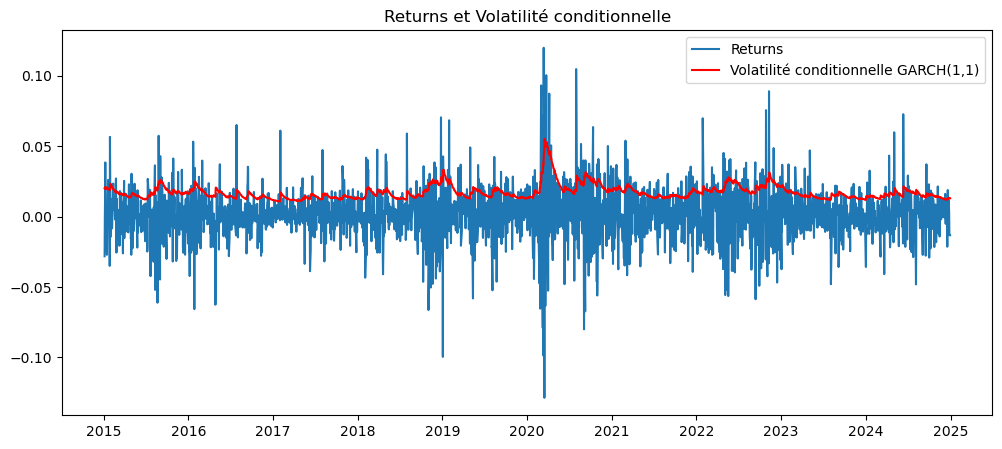

In [79]:
cond_vol = res.conditional_volatility

plt.figure(figsize=(12,5))
plt.plot(returns, label='Returns')
plt.plot(cond_vol, color='red', label='Volatilité conditionnelle GARCH(1,1)')
plt.title('Returns et Volatilité conditionnelle')
plt.legend()
plt.show()

In [80]:
print("AIC:", res.aic)
print("BIC:", res.bic)

AIC: -13539.4698399886
BIC: -13516.151318432


In [81]:
print(res.loglikelihood)

6773.7349199943


In [82]:
from statsmodels.stats.diagnostic import acorr_ljungbox

std_resid = res.resid / res.conditional_volatility

# Test de Ljung-Box (autocorrélation)
lb_test = acorr_ljungbox(std_resid, lags=[10], return_df=True)
print(lb_test)

      lb_stat  lb_pvalue
10  21.049103   0.020754


## T-GARCH model

                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                   AAPL   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:                6807.63
Distribution:                  Normal   AIC:                          -13605.3
Method:            Maximum Likelihood   BIC:                          -13576.1
                                        No. Observations:                 2514
Date:                Thu, Oct 30 2025   Df Residuals:                     2513
Time:                        19:00:22   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.1450e-03  3.060e-04      3.742  1.828e-04 [5.

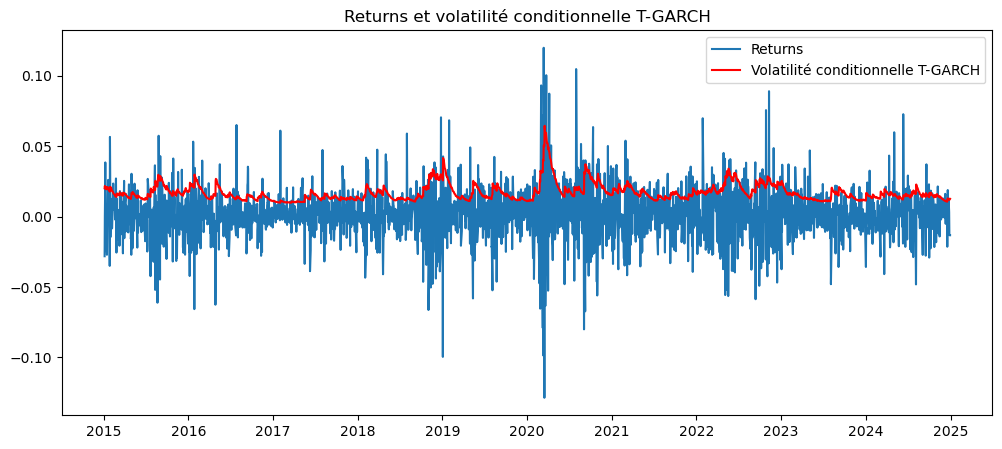

In [83]:
tgarch = arch_model(returns, vol='Garch', p=1, o=1, q=1, dist='normal')

res_tgarch = tgarch.fit(update_freq=5, disp='off')
print(res_tgarch.summary())

cond_vol = res_tgarch.conditional_volatility

plt.figure(figsize=(12,5))
plt.plot(returns, label='Returns')
plt.plot(cond_vol, color='red', label='Volatilité conditionnelle T-GARCH')
plt.title('Returns et volatilité conditionnelle T-GARCH')
plt.legend()
plt.show()

## Test de l'hypothèse H

In [84]:
params = res_tgarch.params
alpha_plus = params['alpha[1]']   # α+
alpha_minus = params['gamma[1]']  # α⁻

# Cov Matrix 
cov = res_tgarch.param_cov  # ou res_tgarch.covariance selon la version

idx_alpha = list(params.index).index('alpha[1]')
idx_gamma = list(params.index).index('gamma[1]')

# Variance de la différence α⁻ - α⁺
var_diff = cov.iloc[idx_gamma, idx_gamma] + cov.iloc[idx_alpha, idx_alpha] - 2*cov.iloc[idx_gamma, idx_alpha]

# Wald statistic
wald_stat = (alpha_minus - alpha_plus)**2 / var_diff
p_value = 1 - stats.chi2.cdf(wald_stat, df=1)

print("alpha- :", alpha_minus)
print("alpha+ :", alpha_plus)
print("Wald stat:", wald_stat)
print("p-value:", p_value)

alpha- : 0.09997004853904111
alpha+ : 0.009999579647782723
Wald stat: 13.185023129651235
p-value: 0.0002821953316890502


## E-GARCH

In [85]:
egarch = arch_model(returns, vol='EGarch', p=1, q=1, dist='normal')
res_egarch = egarch.fit(update_freq=5, disp='off')
print(res_egarch.summary())

                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                   AAPL   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:                6784.29
Distribution:                  Normal   AIC:                          -13560.6
Method:            Maximum Likelihood   BIC:                          -13537.3
                                        No. Observations:                 2514
Date:                Thu, Oct 30 2025   Df Residuals:                     2513
Time:                        19:00:23   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.7985e-03  5.644e-04      3.187  1.440e-03 [6.

                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                   AAPL   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:                6784.29
Distribution:                  Normal   AIC:                          -13560.6
Method:            Maximum Likelihood   BIC:                          -13537.3
                                        No. Observations:                 2514
Date:                Thu, Oct 30 2025   Df Residuals:                     2513
Time:                        19:00:23   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.7985e-03  5.644e-04      3.187  1.440e-03 [6.

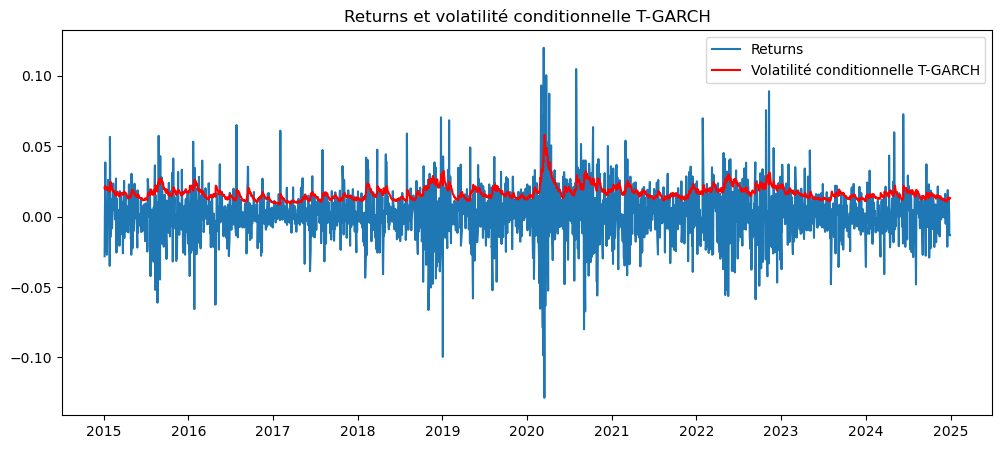

In [86]:
res_egarch = egarch.fit(update_freq=5, disp='off')
print(res_egarch.summary())

cond_vol = res_egarch.conditional_volatility

# 4. Plot des retours et de la volatilité
plt.figure(figsize=(12,5))
plt.plot(returns, label='Returns')
plt.plot(cond_vol, color='red', label='Volatilité conditionnelle T-GARCH')
plt.title('Returns et volatilité conditionnelle T-GARCH')
plt.legend()
plt.show()

# Conclusion

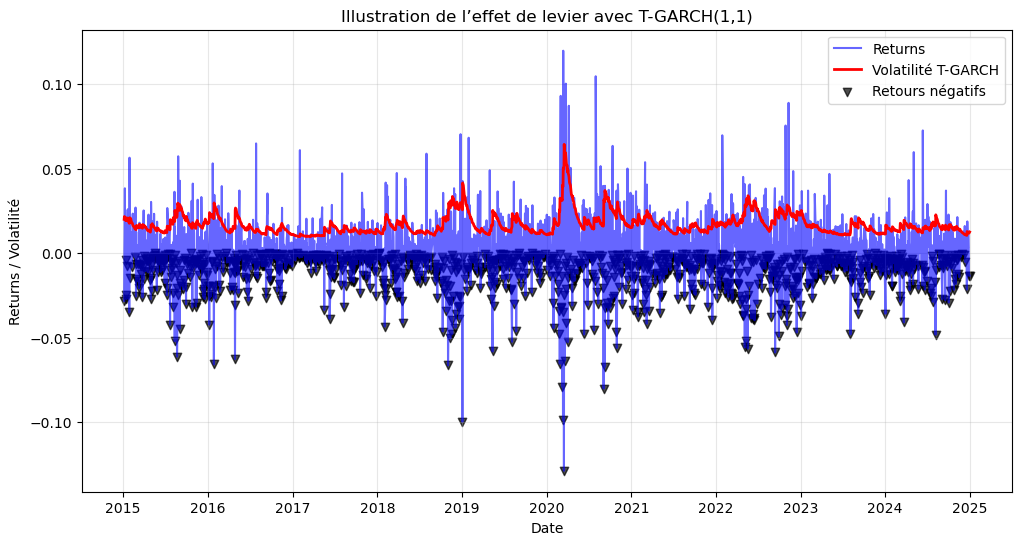

In [87]:
rets = returns["AAPL"]

vol_tgarch = res_tgarch.conditional_volatility

neg_mask = rets < 0

plt.figure(figsize=(12,6))

plt.plot(rets.index, rets, label='Returns', color='blue', alpha=0.6)

plt.plot(vol_tgarch.index, vol_tgarch, label='Volatilité T-GARCH', color='red', linewidth=2)

plt.scatter(rets.index[neg_mask], rets[neg_mask], color='black', marker='v', label='Retours négatifs', alpha=0.7)

plt.title('Illustration de l’effet de levier avec T-GARCH(1,1)')
plt.xlabel('Date')
plt.ylabel('Returns / Volatilité')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [88]:
# 1. GARCH(1,1) 
garch11 = arch_model(returns, vol='Garch', p=1, q=1, dist='normal')
res_garch = garch11.fit(disp='off')

# 2. T-GARCH(1,1)
tgarch11 = arch_model(returns, vol='Garch', p=1, o=1, q=1, dist='normal')
res_tgarch = tgarch11.fit(disp='off')

print("GARCH(1,1) : AIC =", res_garch.aic, ", BIC =", res_garch.bic)
print("T-GARCH(1,1) : AIC =", res_tgarch.aic, ", BIC =", res_tgarch.bic)

GARCH(1,1) : AIC = -13539.4698399886 , BIC = -13516.151318432
T-GARCH(1,1) : AIC = -13605.257048188083 , BIC = -13576.108896242333


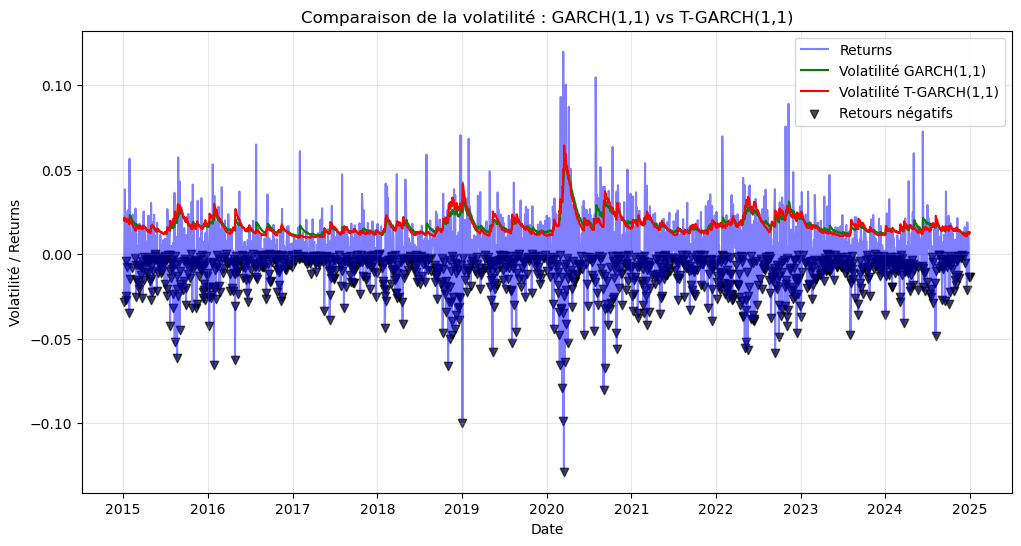

In [89]:
vol_garch = res_garch.conditional_volatility
vol_tgarch = res_tgarch.conditional_volatility

rets = returns.iloc[:,0] if isinstance(returns, pd.DataFrame) else returns
neg_mask = rets < 0

plt.figure(figsize=(12,6))

plt.plot(rets.index, rets, color='blue', alpha=0.5, label='Returns')
plt.plot(vol_garch.index, vol_garch, color='green', label='Volatilité GARCH(1,1)')
plt.plot(vol_tgarch.index, vol_tgarch, color='red', label='Volatilité T-GARCH(1,1)')

plt.scatter(rets.index[neg_mask], rets.loc[neg_mask], color='black', marker='v', label='Retours négatifs', alpha=0.7)

plt.title("Comparaison de la volatilité : GARCH(1,1) vs T-GARCH(1,1)")
plt.xlabel("Date")
plt.ylabel("Volatilité / Returns")
plt.legend()
plt.grid(alpha=0.3)
plt.show()